
## Proyecto: Modelado Matemático de un **Cohete de Agua** (Jupyter Notebook)
**Autor:** Osbaldo Aragón 

**Fecha:** 2025-10-23  

**Curso:** STEM – Python + Cohetes de Agua + ESP32

## Objetivo
Desarrollar un **modelo matemático y una simulación** para estimar:
- La **altura máxima (apogeo)** del cohete.
- El **tiempo de expulsión de agua** (fase de empuje).
- La **velocidad en función del tiempo**, junto con la altura vs tiempo.
- Variables ajustables: presión inicial, fracción de agua, diámetro de tobera, masa seca, coeficiente de arrastre, etc.


## Requisitos
- Python 3.9+
- Paquetes: `numpy`, `matplotlib`, `scipy` (opcional). En este notebook usaremos `numpy` y `matplotlib`.
- VS Code con la extensión **Jupyter**.



## Modelo físico (resumen de hipótesis)
Modelaremos dos fases principales:
1. **Fase de expulsión de agua (empuje)**: la **presión del aire comprimido** dentro de la botella impulsa el agua a través de la **tobera**.  
   - El aire se expande **politrópicamente**: $P V^{n} = \text{cte}$ (usaremos $\approx 1.2$ como aproximación adiabática suave).
   - La velocidad de chorro del agua se aproxima con **Bernoulli**:  
     $v_e = \sqrt{2 (P_{int} - P_{atm}) / \rho_{agua}}$
   - Gasto volumétrico $Q = A_{tobera} \, v_e$, $\dot m = \rho_{agua} \, Q$
   - Empuje: $T \approx \dot m \, v_e$ (suponiendo presión de salida $\approx P_{atm}$).
2. **Fase de ascenso balístico (sin empuje)**: tras agotar el agua, el cohete asciende por inercia con **arrastre aerodinámico**:  
   $D = \tfrac{1}{2} \rho_{aire} C_d A_{ref} v^2$

**Ecuaciones de movimiento (vertical, sin viento):**
- Durante empuje: $ m(t) \, \dot v = T - m(t) g - D(v)$, y $\dot h = v $
- Durante ascenso libre: $ m = \text{constante (masa seca)} $, $ \dot v = -g - D(v)/m $, $\dot h = v $

**Actualización de presión interna durante el empuje:**
- El volumen de aire $V_a$ aumenta conforme sale el agua: $ V_a(t) = V_{a0} + (V_{botella} - V_{agua}(t)) - (V_{botella} - V_{agua0}) $.  
- Por politrópica: $ P_{int}(t) = P_{0,abs} \big(\tfrac{V_{a0}}{V_a(t)}\big)^{n} $.  
  Aquí $P_{0,abs} = P_{atm} + P_{gauge}$ es la presión absoluta inicial.

> **Simplificación**: ignoramos la pequeña fase de “chorro de aire” tras agotar el agua; su contribución al empuje suele ser pequeña con cuellos típicos.



## Parámetros de entrada
Sugerencia de valores iniciales para una **botella de 2 L**:
- Volumen total botella `V_b = 2.0e-3 m³` (2 L).
- Fracción de agua inicial `f_w = 1/3` (≈ 0.666 L).
- Presión manométrica inicial (gauge) `P_gauge = 120 psi` (≈ 413,500 Pa).
- Presión atmosférica `P_atm = 101,325 Pa`.
- Diámetro de tobera `d_noz = 5 mm`.
- Masa seca (botella+estructura) `m_dry` (ej. 0.15–0.25 kg).
- Coeficiente de arrastre `C_d` (ej. 0.5–0.9) y área de referencia `A_ref` (según geometría).
- Exponente politrópico `n ≈ 1.2`.


In [1]:

# === Parámetros ===
import numpy as np

# Geometría y masas
V_b = 2.0e-3          # m^3   volumen botella (2 L)
f_w = 1/3             # fracción de agua (ajustable)
rho_w = 1000.0        # kg/m^3 densidad del agua
m_dry = 0.100         # kg     masa seca (botella + aletas + electrónica)

# Tobera
d_noz = 10e-3          # m  diámetro de la tobera (10 mm)
A_noz = np.pi*(d_noz/2)**2

# Presiones
P_atm = 101325.0      # Pa
P_gauge = 60.0 * 6894.757 # 60 psi -> Pa (1 psi = 6894.757 Pa)
P0_abs = P_atm + P_gauge   # Pa presión absoluta inicial dentro

# Aire y gravedad
rho_air = 0.95      # kg/m^3 a ~28 °C nivel de santiago (aprox.)
g = 9.80665           # m/s^2

# Arrastre
C_d = 0.6             # coeficiente de arrastre (ajustable)
A_ref = 0.008         # m^2 área frontal (aprox. botella 90 mm Ø -> A ~ pi*(0.045)^2 ≈ 0.0064–0.008 m^2)

# Expansión politrópica
n_exp = 1.2           # exponente politrópico (≈ adiabático suave)

# Configuración de simulación
dt = 1e-4             # s paso de integración fino para fase de agua
dt_coast = 1e-3       # s paso para fase balística
t_max = 10.0          # s tiempo max de simulación (seguridad)



## Funciones auxiliares
Incluye cálculo de:
- Presión interna por politrópica.
- Velocidad de chorro y caudal.
- Fuerza de arrastre (depende de velocidad).


In [2]:

def air_pressure_polytropic(P0_abs, Va0, Va, n):
    """Devuelve P_abs interna por expansión politrópica: P*V^n = cte."""
    return P0_abs * (Va0 / Va)**n

def jet_velocity(P_int_abs, P_atm, rho_w):
    """Velocidad del chorro por Bernoulli (si P_int > P_atm)."""
    deltaP = max(P_int_abs - P_atm, 0.0)
    return np.sqrt(2.0 * deltaP / rho_w)

def drag_force(rho, Cd, A, v):
    """Magnitud de la fuerza de arrastre (opuesta a v): 0.5 * rho * Cd * A * v^2."""
    return 0.5 * rho * Cd * A * v**2



## Simulación: Fase de **expulsión de agua**
Integramos en pasos \(dt\) hasta que el **volumen de agua llegue a cero** o la **presión ya no pueda expulsarla**.
Guardamos (t, h, v, m, P, \dot m, T) para graficar y calcular el **tiempo de expulsión**.


In [3]:

# Estados iniciales
V_water0 = V_b * f_w                # m^3
Va0 = V_b - V_water0                # m^3 (volumen de aire inicial)
m_water0 = rho_w * V_water0         # kg
m = m_dry + m_water0                # masa total inicial
h = 0.0                             # m altura
v = 0.0                             # m/s velocidad
t = 0.0                             # s tiempo

# Almacenamiento de historial (fase agua)
t_list = []
h_list = []
v_list = []
m_list = []
P_list = []
mdot_list = []
T_list = []

V_water = V_water0
Va = Va0
burnout = None

while t < t_max and V_water > 0:
    # Presión interna por politrópica
    P_int = air_pressure_polytropic(P0_abs, Va0, Va, n_exp)
    ve = jet_velocity(P_int, P_atm, rho_w)

    if ve <= 1e-8:
        # Ya no hay deltaP útil para expulsar agua
        break

    Q = A_noz * ve                     # m^3/s caudal volumétrico
    mdot = rho_w * Q                   # kg/s gasto másico (agua saliendo)
    T = mdot * ve                      # N empuje (simplificado)

    # Fuerza de arrastre (opuesta a v)
    D = drag_force(rho_air, C_d, A_ref, abs(v))
    D *= np.sign(v)                    # dar dirección (opuesta a v)

    # Dinámica (vertical hacia arriba positiva)
    # m(t) decrece por salida de agua
    a = (T - m*g - (-D)) / m if v >= 0 else (T - m*g + D) / m  # corregimos signo del arrastre
    # Nota: más claro: fuerza neta = T - m*g - D*sign(v)
    F_net = T - m*g - D*np.sign(v) if v != 0 else T - m*g
    a = F_net / m

    # Integración explícita (Euler)
    v = v + a*dt
    h = max(h + v*dt, 0.0)

    # Actualizar agua/masa/volúmenes
    dVw = Q * dt
    if dVw > V_water:
        dVw = V_water  # evitar pasar de cero
    V_water -= dVw
    Va = V_b - V_water
    dm = rho_w * dVw
    m -= dm

    # Guardar
    t_list.append(t)
    h_list.append(h)
    v_list.append(v)
    m_list.append(m)
    P_list.append(P_int)
    mdot_list.append(mdot)
    T_list.append(T)

    # Avanzar tiempo
    t += dt

# Tiempo de expulsión de agua
t_burn = t
burnout = (t, h, v, m)
t_burn, h, v, m


(0.35129999999997763,
 np.float64(5.792329920861945),
 np.float64(41.99634065877217),
 np.float64(0.1000000000000004))


## Simulación: Fase **balística** (sin empuje)
Tras el agotamiento del agua, integramos con arrastre y gravedad hasta que la **velocidad cambia de signo** (apogeo).


In [4]:

# Estados al inicio del coast
t_c = t_burn
h_c = burnout[1]
v_c = burnout[2]
m_c = burnout[3]  # ~ m_dry si todo el agua se agotó

t2_list = []
h2_list = []
v2_list = []

t = t_c
h = h_c
v = v_c
m = m_c

apogee_reached = False
while t < t_max and not apogee_reached:
    # Fuerza de arrastre
    D = drag_force(rho_air, C_d, A_ref, abs(v))
    # Ecuaciones de movimiento sin empuje
    F_net = -m*g - D*np.sign(v) if v != 0 else -m*g
    a = F_net / m

    v = v + a*dt_coast
    h = h + v*dt_coast
    if h < 0:
        h = 0
        v = 0
        apogee_reached = True

    t += dt_coast
    t2_list.append(t)
    h2_list.append(h)
    v2_list.append(v)

    # Apogeo (cuando v cruza 0 de + a -)
    if len(v2_list) > 2 and v2_list[-2] > 0 and v2_list[-1] <= 0:
        apogee_reached = True

# Altura máxima
h_apogee = max(h_list + h2_list) if (h2_list) else max(h_list)
t_total = (t2_list[-1] if t2_list else t_burn)
h_apogee, t_burn, t_total


(np.float64(41.48351503172491), 0.35129999999997763, 2.703299999999791)


## Resultados numéricos
- **Tiempo de expulsión de agua** (aprox): `t_burn`  
- **Altura máxima (apogeo)**: `h_apogee`  
- **Tiempo total hasta apogeo**: `t_total`  
> Recuerda: estos valores dependen fuertemente de los parámetros (tobera, presión, fracción de agua, masa seca, Cd, A_ref, etc.).


In [5]:

print(f"Tiempo expulsión de agua (s): {t_burn:.4f}")
print(f"Altura máxima (m): {h_apogee:.2f}")
print(f"Tiempo hasta apogeo (s): {t_total:.2f}")


Tiempo expulsión de agua (s): 0.3513
Altura máxima (m): 41.48
Tiempo hasta apogeo (s): 2.70



## Gráficas principales
Se generan las gráficas de **velocidad vs tiempo** y **altura vs tiempo**, indicando el fin de la fase de agua.


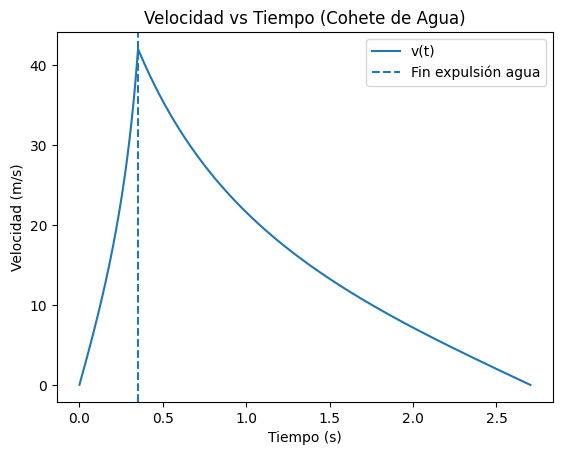

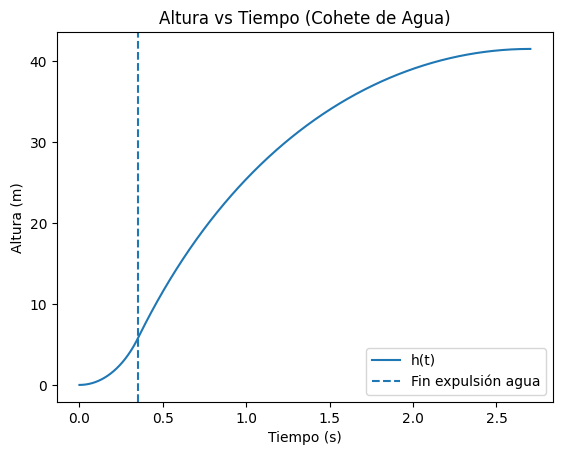

In [6]:

import matplotlib.pyplot as plt

# Concatenar series para gráficas completas
t_all = np.array(t_list + t2_list)
v_all = np.array(v_list + v2_list)
h_all = np.array(h_list + h2_list)

# Marcas de burnout
t_b = t_burn

# Velocidad vs Tiempo
plt.figure()
plt.plot(t_all, v_all, label='v(t)')
plt.axvline(t_b, linestyle='--', label='Fin expulsión agua')
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad (m/s)')
plt.title('Velocidad vs Tiempo (Cohete de Agua)')
plt.legend()
plt.show()

# Altura vs Tiempo
plt.figure()
plt.plot(t_all, h_all, label='h(t)')
plt.axvline(t_b, linestyle='--', label='Fin expulsión agua')
plt.xlabel('Tiempo (s)')
plt.ylabel('Altura (m)')
plt.title('Altura vs Tiempo (Cohete de Agua)')
plt.legend()
plt.show()



## Exploración paramétrica (opcional)
Pequeña función para explorar rápidamente **cómo cambia el apogeo** con parámetros clave (ej. presión o fracción de agua).  
> Sugerencia de actividad: pedir a los alumnos barrer **fracción de agua** y **diámetro de tobera** para identificar combinaciones que maximizan altura sin perder estabilidad.


In [7]:

def sim_apogee(P_gauge_psi=None, frac_water=None, d_noz_mm=None):
    # Copia de parámetros base (simple, no OOP para mayor claridad)
    V_b_loc = V_b
    rho_w_loc = rho_w
    m_dry_loc = m_dry
    P_atm_loc = P_atm
    g_loc = g
    rho_air_loc = rho_air
    C_d_loc = C_d
    A_ref_loc = A_ref
    n_loc = n_exp
    dt1 = dt
    dt2 = dt_coast

    f_w_loc = frac_water if frac_water is not None else f_w
    d_noz_loc = (d_noz_mm/1000.0) if d_noz_mm is not None else d_noz
    A_noz_loc = np.pi*(d_noz_loc/2)**2

    P0_abs_loc = P_atm_loc + ((P_gauge_psi if P_gauge_psi is not None else (P_gauge/6894.757)) * 6894.757)

    # Estados iniciales
    V_water0 = V_b_loc * f_w_loc
    Va0 = V_b_loc - V_water0
    m_water0 = rho_w_loc * V_water0
    m = m_dry_loc + m_water0
    h = 0.0
    v = 0.0
    t = 0.0
    V_water = V_water0
    Va = Va0

    # Fase agua
    while t < t_max and V_water > 0:
        P_int = air_pressure_polytropic(P0_abs_loc, Va0, Va, n_loc)
        ve = jet_velocity(P_int, P_atm_loc, rho_w_loc)
        if ve <= 1e-8:
            break
        Q = A_noz_loc * ve
        mdot = rho_w_loc * Q
        T = mdot * ve

        D = drag_force(rho_air_loc, C_d_loc, A_ref_loc, abs(v))
        F_net = T - m*g_loc - D*np.sign(v) if v != 0 else T - m*g_loc
        a = F_net / m

        v = v + a*dt1
        h = max(h + v*dt1, 0.0)

        dVw = Q * dt1
        if dVw > V_water:
            dVw = V_water
        V_water -= dVw
        Va = V_b_loc - V_water
        dm = rho_w_loc * dVw
        m -= dm

        t += dt1

    t_burn_loc = t
    h_burn_loc = h
    v_burn_loc = v
    m_burn_loc = m

    # Fase balística
    while t < t_max:
        D = drag_force(rho_air_loc, C_d_loc, A_ref_loc, abs(v))
        F_net = -m_burn_loc*g_loc - D*np.sign(v) if v != 0 else -m_burn_loc*g_loc
        a = F_net / m_burn_loc

        v = v + a*dt2
        h = h + v*dt2
        t += dt2
        if h < 0:
            h = 0
            break
        if v <= 0 and t > t_burn_loc + 1e-3:
            # apogeo alcanzado
            break
    return h, t_burn_loc

# Ejemplo de uso (rápido)
h_est, t_b = sim_apogee(P_gauge_psi=120, frac_water=1/3, d_noz_mm=5)
print(f"Apogeo estimado (m): {h_est:.2f} | Tiempo de expulsión (s): {t_b:.4f}")


Apogeo estimado (m): 63.11 | Tiempo de expulsión (s): 0.9723



## Actividades sugeridas para los alumnos
1. **Validación experimental:** Comparar apogeo y tiempo de expulsión medidos vs. simulados (usar video y cronómetro).
2. **Barridos paramétricos:** Variar `f_w`, `d_noz`, `P_gauge` y `m_dry` para encontrar combinaciones que **maximicen la altura**.
3. **Estimación de \(C_d\):** Ajustar \(C_d\) para que la curva de altura simulada coincida con la experimental (calibración).
4. **Reporte técnico:** Incluir supuestos, ecuaciones, parámetros, resultados, discusión de errores y recomendaciones de diseño (aletas, masa, boquilla).
5. **Extra (ESP32):** Registrar presión/altitud con un BMP180 y comparar la **curva h(t)** real vs. simulada.



## Apéndice: Fórmulas clave
- **Bernoulli (chorro):** $ v_e = \sqrt{2 (P_{int} - P_{atm}) / \rho_w} $
- **Politrópica:** $ P\,V^{n} = \text{cte} \Rightarrow P = P_0 \left(\frac{V_{a0}}{V_a}\right)^n $
- **Empuje (agua):** $ T \approx \dot m\, v_e,\ \dot m = \rho_w A_{noz} v_e $
- **Arrastre:** $ D = \tfrac{1}{2}\rho_{air} C_d A_{ref} v^2 $
- **Movimiento vertical:** $m \dot v = \sum F = T - mg - D\,\text{sign}(v);\ \dot h = v $
